In [1]:
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA

import mne
from scipy import signal
#from mne.time_frequency import fit_iir_model_raw

In [3]:
%matplotlib inline

In [4]:
raw =  mne.io.read_raw_fif("Subject-6_Non-VR.fif", preload=True)

Opening raw data file C:\Users\sonal\EEG\Subject-6_Non-VR.fif...
Isotrak not found
    Range : 0 ... 23015 =      0.000 ...   179.805 secs
Ready.


<ipython-input-4-77c646b56a4f>:1: RuntimeWarning: This filename (C:\Users\sonal\EEG\Subject-6_Non-VR.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw =  mne.io.read_raw_fif("Subject-6_Non-VR.fif", preload=True)


Reading 0 ... 23015  =      0.000 ...   179.805 secs...


In [5]:
nchan = raw.info['nchan']
raw.info['ch_names']

['CH 1', 'CH 3', 'CH 4', 'CH 6', 'CH 7', 'CH 8']

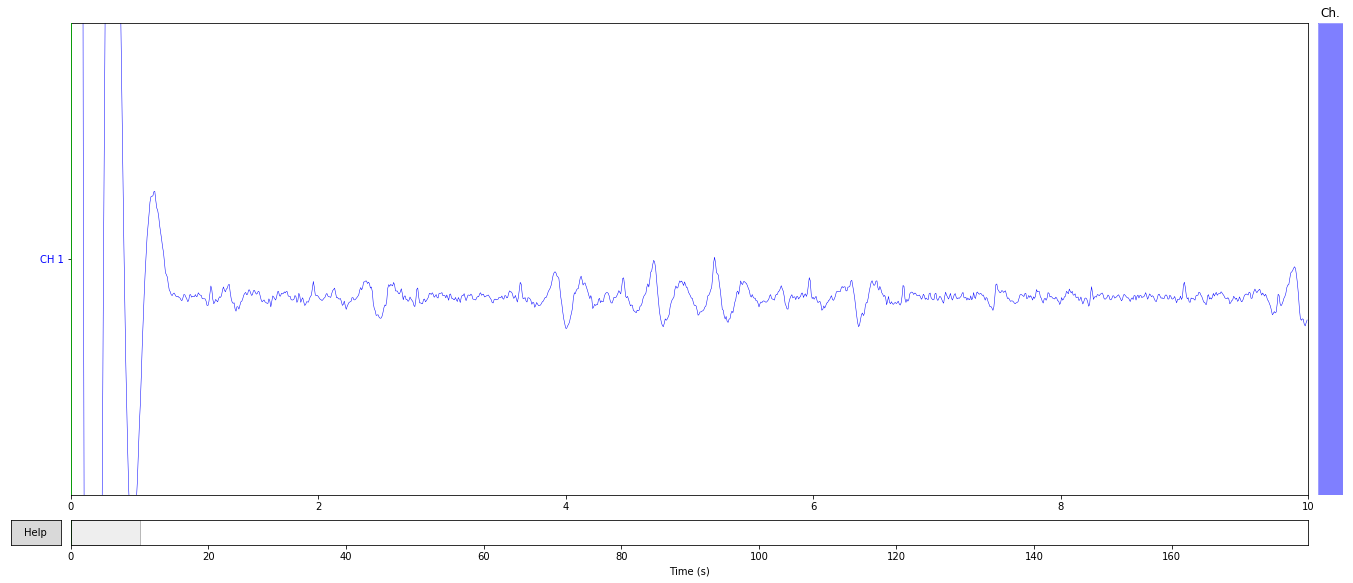

In [24]:
scalings = {'eeg':400,'eeg':400,'eeg':400,'eeg':400,'eeg':400,'eeg':400,'eeg':400,'eeg':400}
color = {'eeg':'blue'}

ch_names = raw.info['ch_names']


raw_pick = raw.pick_channels(["CH 1"])  # getting one channel data | got from https://github.com/mne-tools/mne-python/issues/4699


data1 = pd.Series(raw.get_data()[0]) # Convert channel into pandas series

raw_pick.plot(n_channels=1,scalings=scalings, color=color, title='Data from Channels', show=True, block=True);

Text(0, 0.5, 'MEG data (T)')

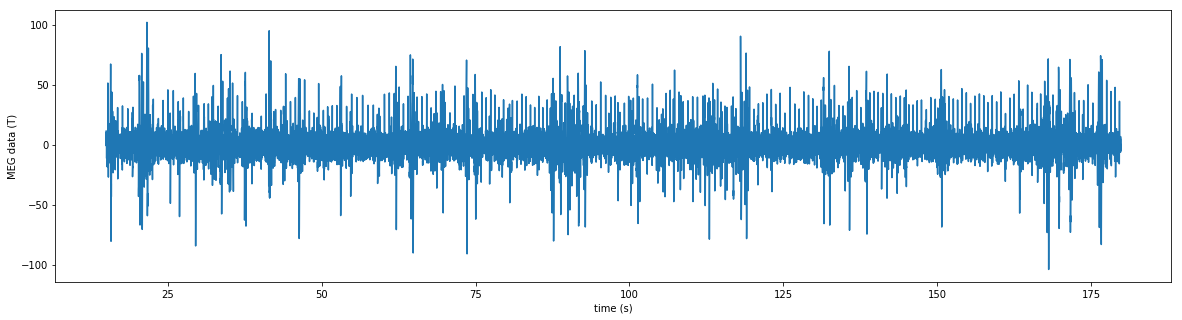

In [7]:
raw_pick = raw.pick_channels(["CH 1"]) # get single channel
start, stop = raw_pick.time_as_index([15, 180]) # 100 s to 115 s data segment

picks = mne.pick_types(raw_pick.info, eeg=True, exclude=[])
data, times = raw_pick[picks[:], start:stop]

import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(times, data.T)
plt.xlabel('time (s)')
plt.ylabel('MEG data (T)')

In [8]:
#data = pd.Series(data)
data1 = data[0].transpose()
times1 = times.transpose()
print(times1)

[ 15.         15.0078125  15.015625  ... 179.7890625 179.796875
 179.8046875]


In [9]:
df = pd.DataFrame(data=[times1,data1])
df = df.transpose()

In [10]:
df.columns = ['Time','Channel']
df.set_index('Time', inplace=True)

In [11]:
df.head()

,Channel
Time,
15.000000,11.278577
15.007812,-0.946135
15.015625,3.356168
15.023438,10.567626
15.031250,7.758375


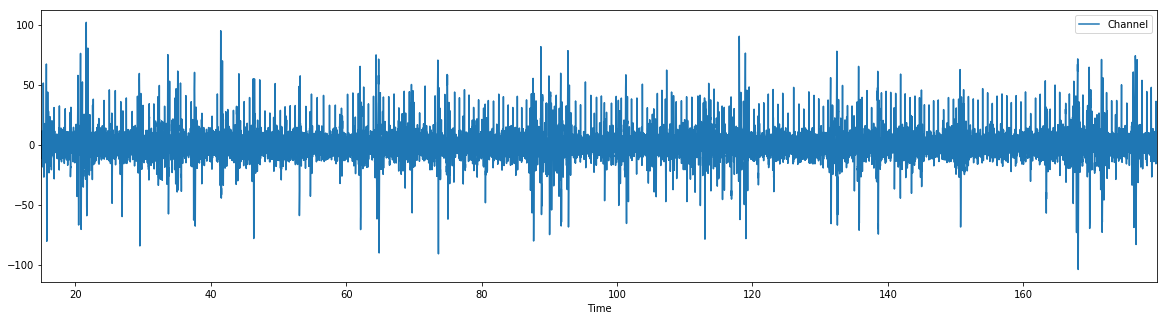

In [12]:
df.plot(figsize=(20,5))

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

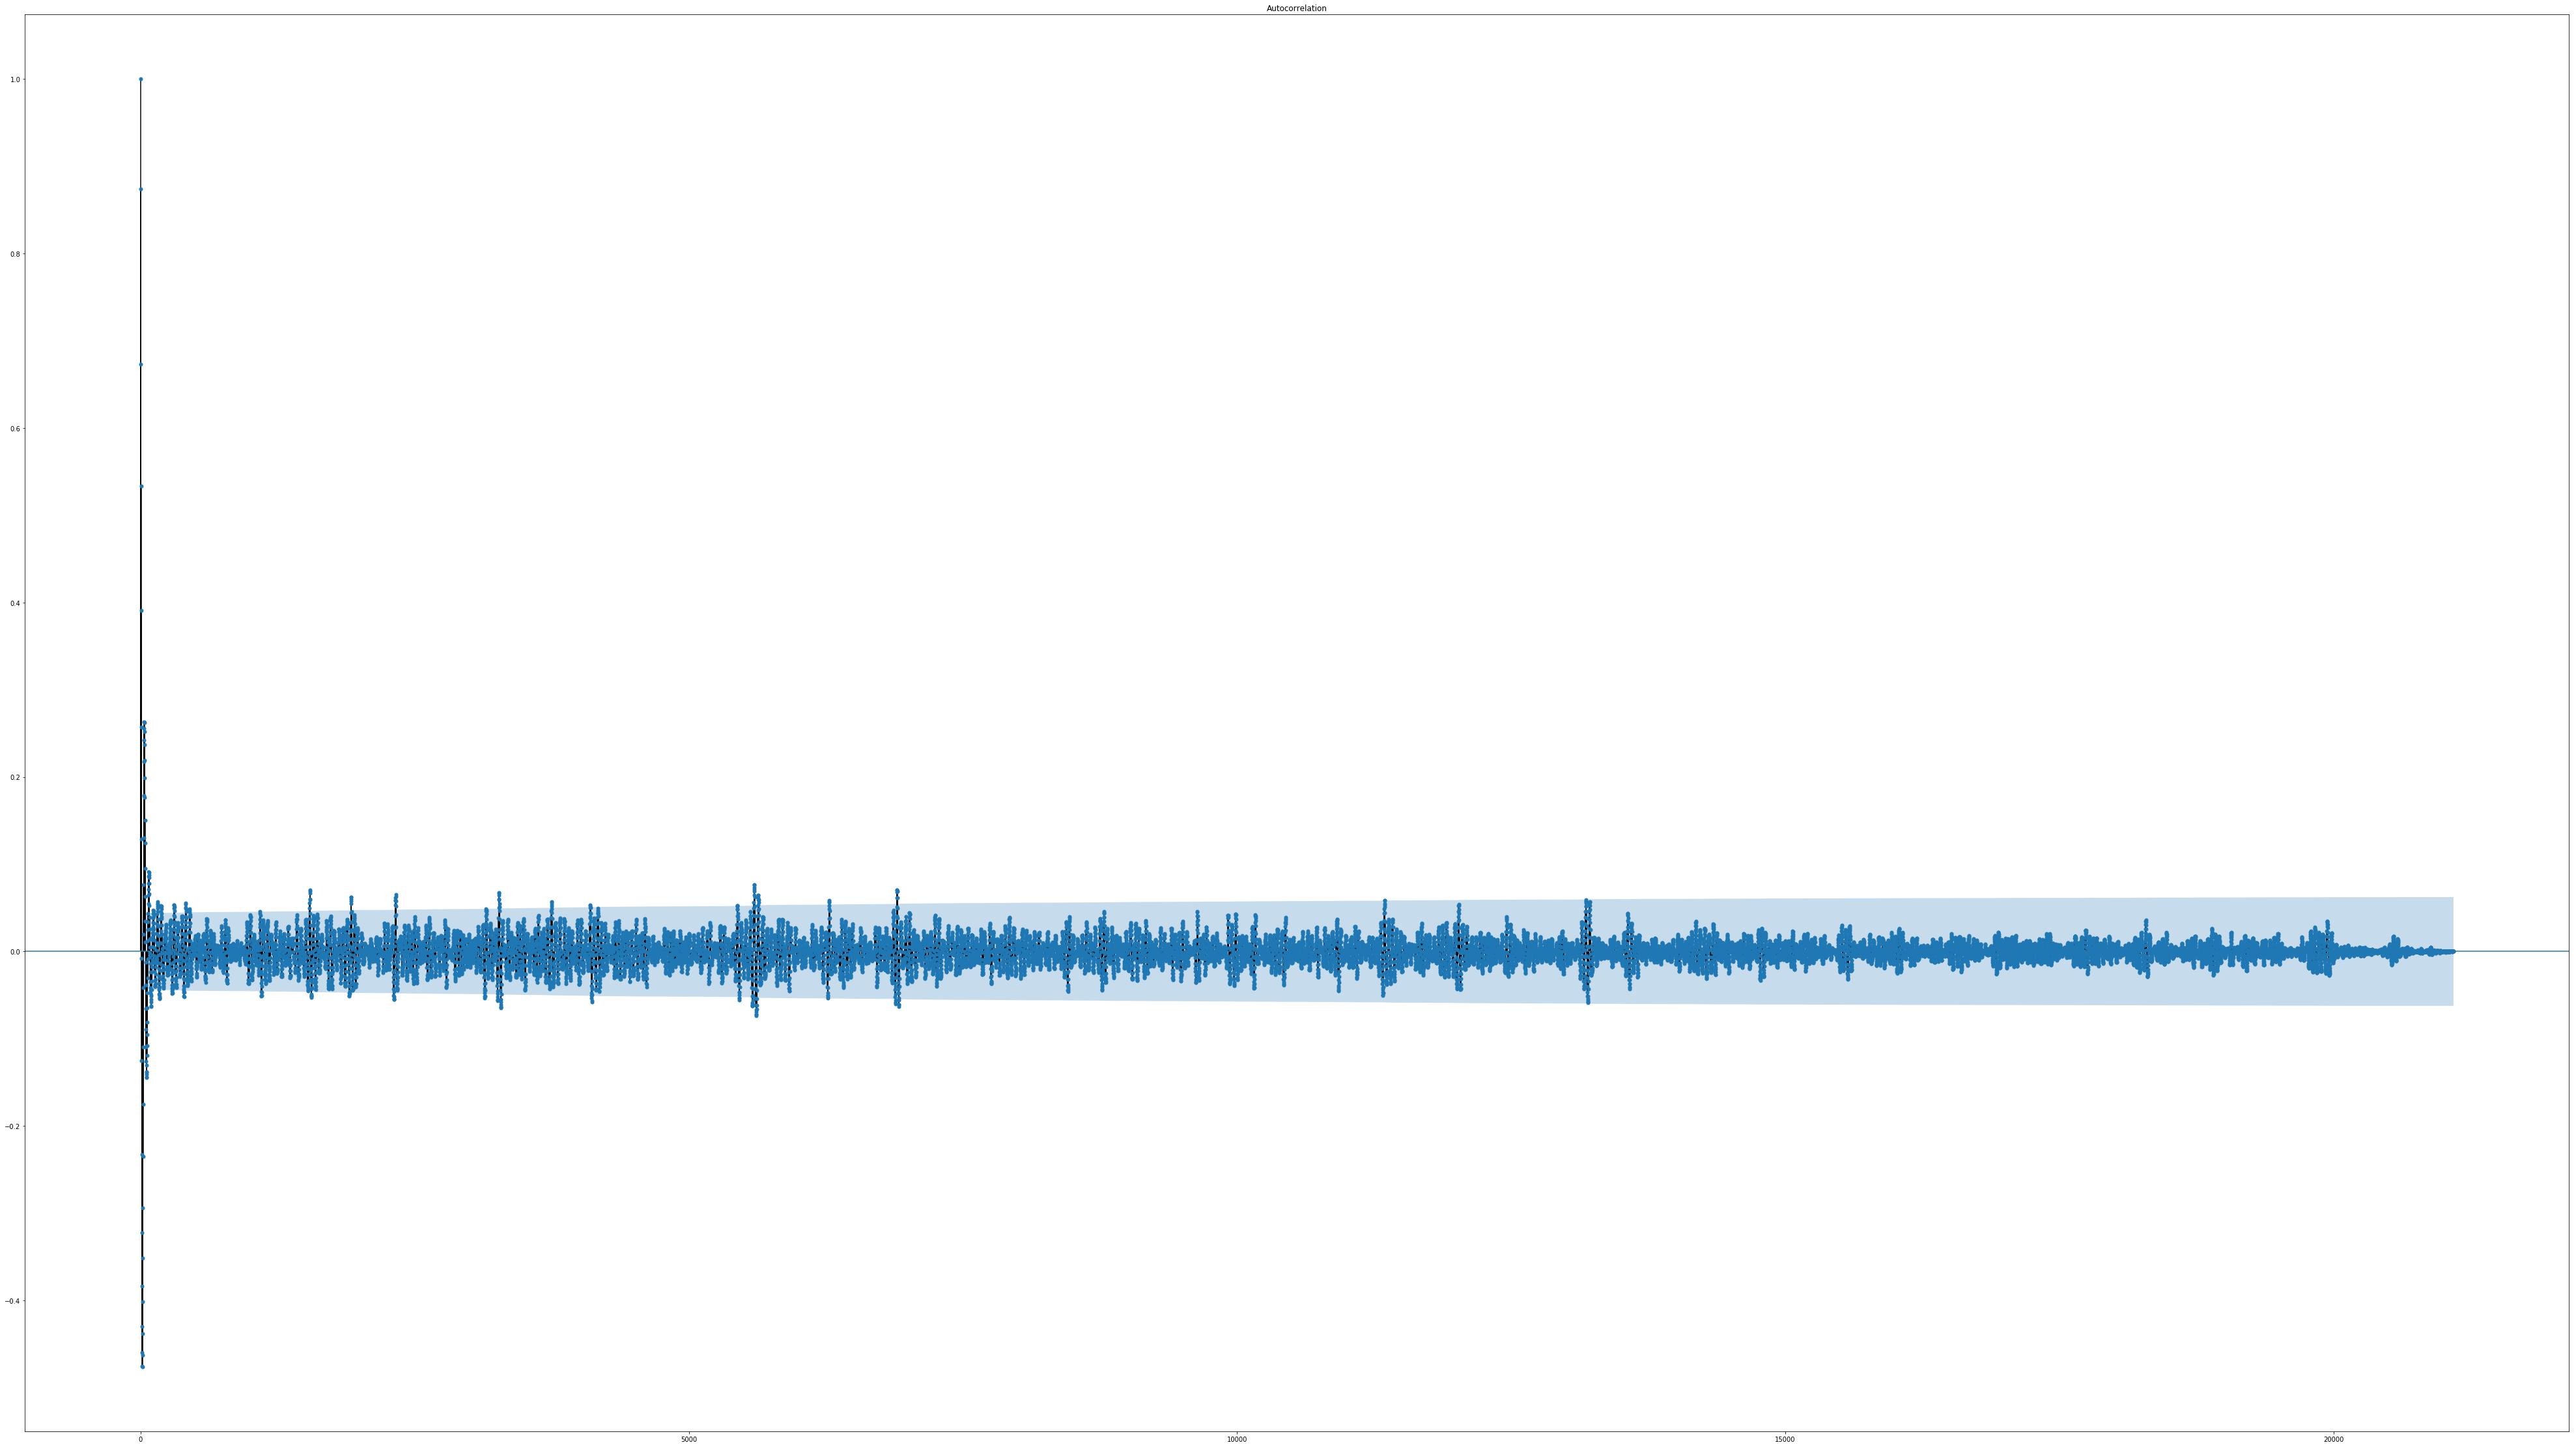

In [14]:
fig, ax = plt.subplots(figsize=(70, 40))
plot_acf(df, ax=ax);

In [15]:
diff = df.diff(periods=1)
# integrated of order 1 because here we are taking 1 lag/1 time difference
# it's denoted by d(diff), one of the parameter of ARIMA model

diff.dropna(inplace=True)
diff.head()

,Channel
Time,
15.007812,-12.224712
15.015625,4.302303
15.023438,7.211458
15.031250,-2.809251
15.039062,1.722395


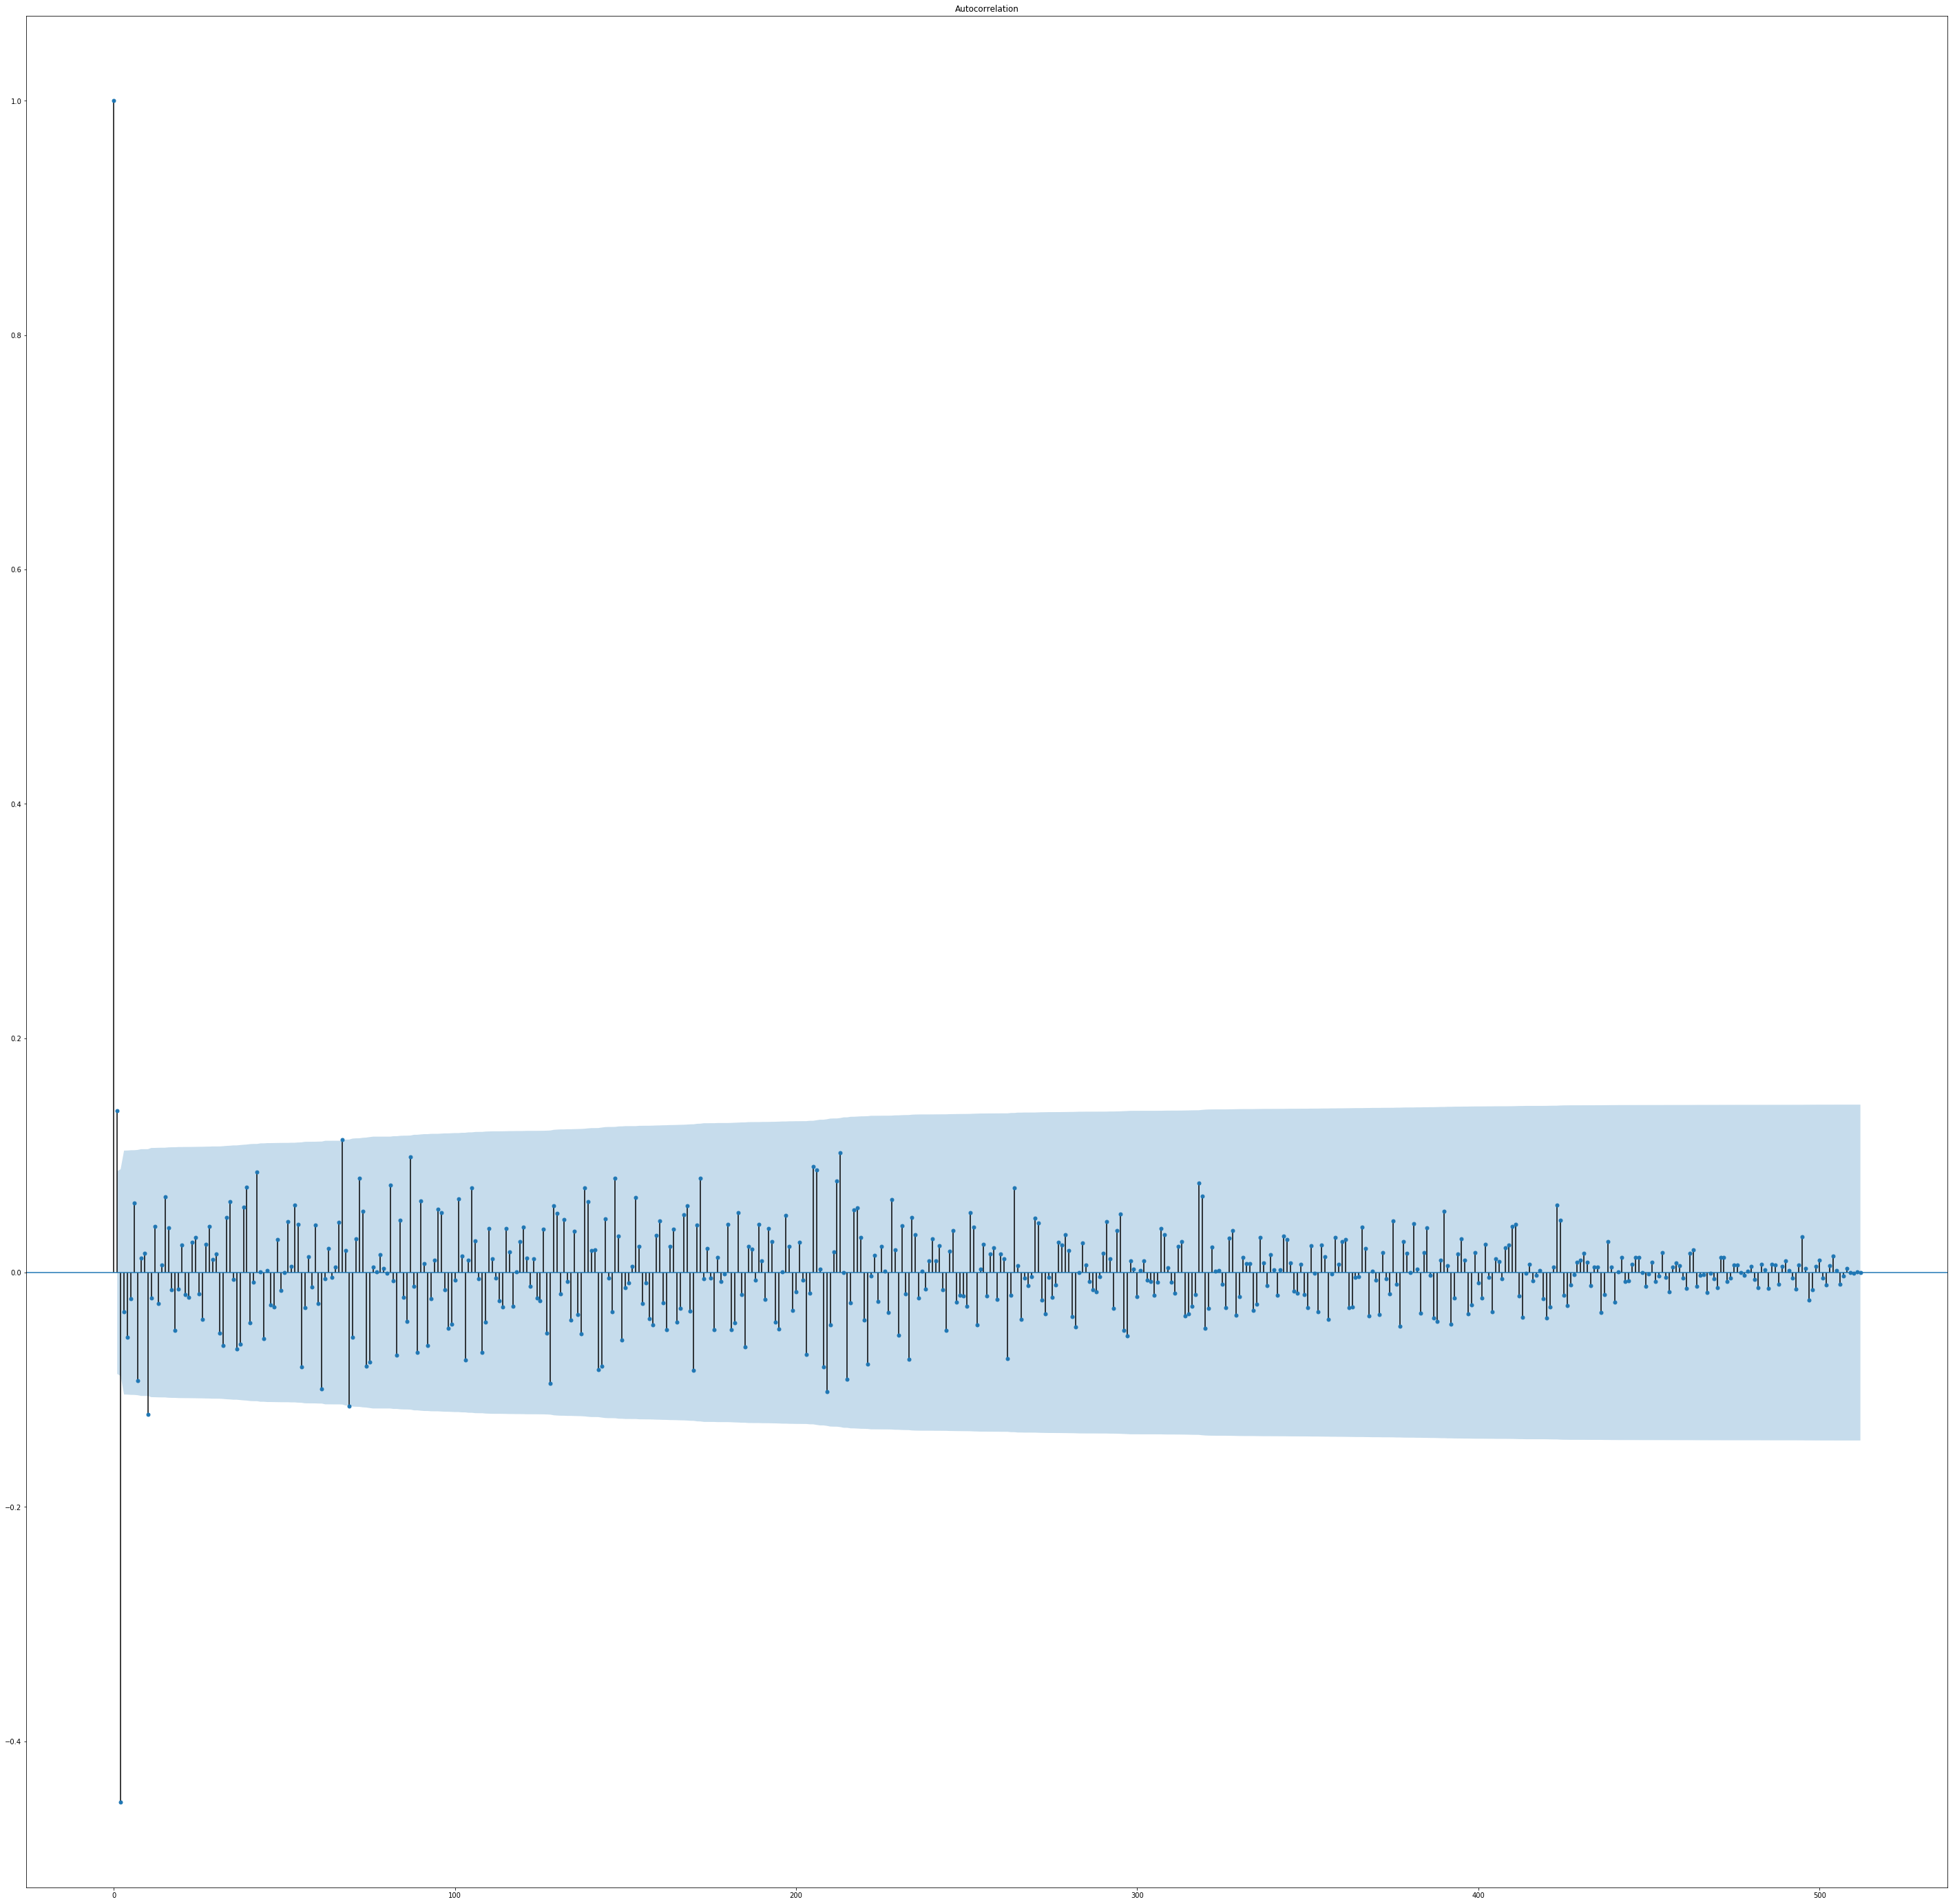

In [16]:
fig, ax = plt.subplots(figsize=(50, 50))
plot_acf(diff[16:20], ax=ax);

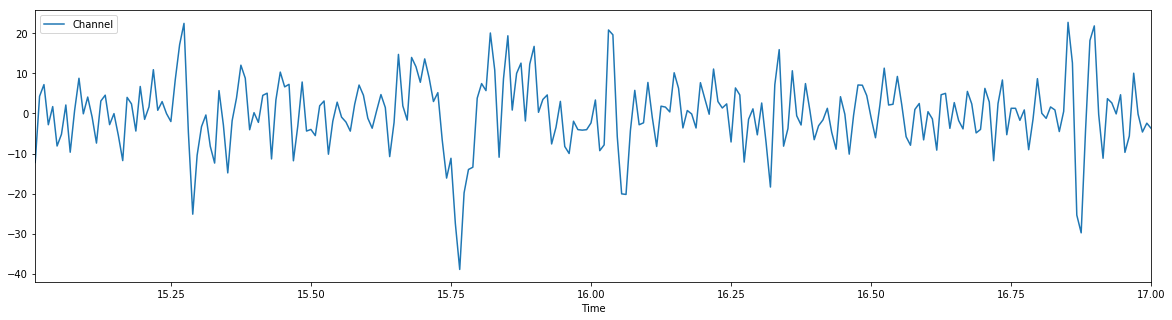

In [17]:
diff[:17].plot(figsize=(20,5))

### Auto regressive (AR)  MODEL

In [18]:
# split the data
X = df.Channel
train = X[0:140]
test = X[138:]
predictions = []
print("Train Size : " ,train.size,"and Test Size : ", test.size)

Train Size :  16001 and Test Size :  5352


In [19]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
model_ar = AR(train)
model_ar_fit = model_ar.fit()

C:\Users\sonal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [20]:
test

Time
138.000000   -1.210500e+01
138.007812   -4.342021e+00
138.015625   -1.577464e+00
138.023438   -2.315953e+00
138.031250    1.653793e+00
138.039062   -1.143840e+00
138.046875    2.551303e-01
138.054688    8.869040e+00
138.062500   -8.771399e-01
138.070312   -3.895167e+00
138.078125    8.355260e+00
138.085938    4.313966e+00
138.093750    2.747369e+00
138.101562    1.368792e+01
138.109375    1.218327e+01
138.117188    1.685335e+00
138.125000    1.949782e+00
138.132812    9.699407e+00
138.140625    1.259716e+01
138.148438    1.452342e+01
138.156250    1.355903e+01
138.164062    9.747194e+00
138.171875    6.688125e+00
138.179688   -1.209379e+00
138.187500   -1.189446e+00
138.195312    6.385508e+00
138.203125    8.947685e+00
138.210938    1.099088e+01
138.218750    5.174294e+00
138.226562   -2.033302e+00
                  ...     
179.578125   -1.387617e+01
179.585938   -5.294763e-01
179.593750    2.640521e+01
179.601562    3.605544e+01
179.609375    1.747361e+01
179.617188    1.970860e

In [21]:
start=len(train)
end=len(train) + len(test)-1

predictions = model_ar_fit.predict(start=start,end=end)
predictions.head()

C:\Users\sonal\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


16001   -4.920973
16002    3.257437
16003   -3.045668
16004   -1.708177
16005    1.533006
dtype: float64

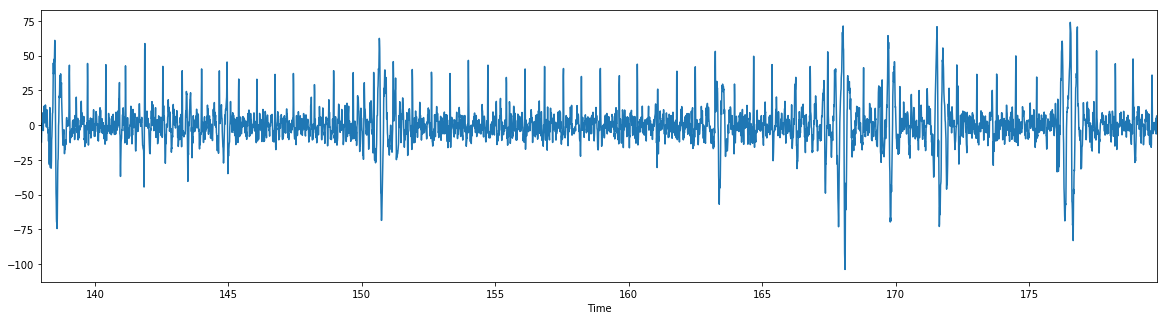

In [22]:
test.plot(figsize=(20,5))

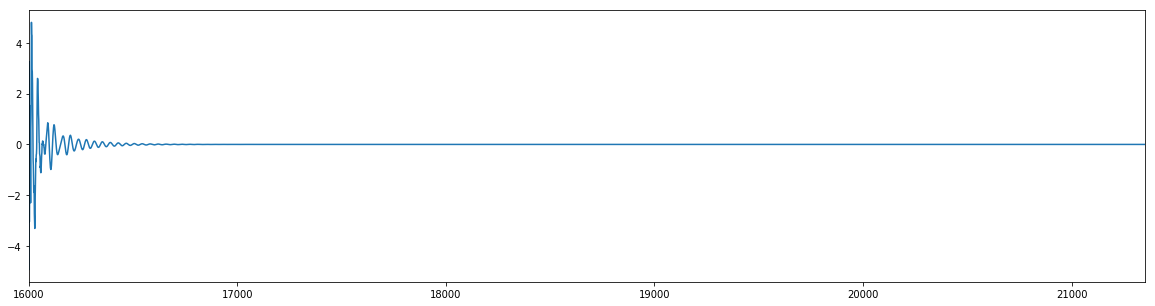

In [23]:
predictions.plot(figsize=(20,5))